## Plotting lat-lon and ZM 

In [1]:
### RBN: 18 Aug 2020: Set up panel plots that can selectively plot full field., bias, and run differences. ###

import numpy as np
import xarray as xr
import pandas as pd

from metpy.interpolate import log_interpolate_1d
from metpy.units import units

import matplotlib.pyplot as mp
from matplotlib import cm
from mpl_toolkits.axes_grid1 import AxesGrid
#from mpl_toolkits.basemap import Basemap as bmap
import matplotlib as mpl

import cartopy
import cartopy.crs as ccrs
import cartopy.util as cutil
 
import cartopy.feature as cfeature # Map features
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from sys import exit

#%xmode Minimal   ## Fortran-like error tracebacks (doesn't seem to work though)

In [2]:
# Set up case/data variables

dir_root = '/glade/p/cgd/amp/people/hannay/amwg/climo/'

ldiff_ctrl = False # Difference compared to the control?
lp3d_if_read_in = True # Plot 3D zonal average if it is read in for another variable.

seas = np.array(['JJA']) # If 2 seasons does 2 columns, if 1 does successive rows.


var_name = 'PRECT'

## Cases to focus on
#case_desc = np.array(['C6','rC5','rUW','rMG1','rC5pm','rpfrac','rZMc'])
#case_desc =  np.array(['C6','C5','rUW','rUW'])
#case_desc = np.array(['C6','rC5','rUW','rMG1','rC5p','rC5pm','rpfrac','rice'])

# TMQ #
#case_desc =  np.array(['C6','C5','rUW','rUW'])

#PRECT
#case_desc = np.array(['C6','C5','rC5','rUW','rUWp','rMG1','rpfrac','rTMS','rZMc','rZMp','rice','rpremit','rM3'])


#SWCF
#case_desc = np.array(['C6','rC5','rUW','rMG1','rC5p','rC5pm','rpfrac','rice'])

#LWCF
#case_desc = np.array(['C6','rC5','rUW','rMG1','rUWp','rC5pm','rice','rZMc'])
#case_desc = np.array(['C6','rC5','rUW','rUWp','rMG1','rpfrac','rice','rC5pm','rZMc'])
#case_desc = np.array(['C6','rC5','rCE2i',])
#case_desc = np.array(['C6','rC5','rUW','rMG1'])

#AODVIS
#case_desc = np.array(['C6','rC5','rUW','rUWp','rC5pm','rC5pdust','rC5psalt','rTMS'])
##case_desc = np.array(['C6','rC5','rUW','rUWp'])

#SST cases
#case_desc =  np.array(['C6','AMdsst','CE2','CE2sst','CE2dsst','CE2csst'])
#case_lname = np.array(['AMIP (monthly)','AMIP (daily)','Coupled','Coupled (monthly)','Coupled (daily)','Coupled (climo.)'])

# Limited SST cases
#case_desc =  np.array(['C6','AMdsst','CE2','CE2sst','C5','CE1'])
#case_lname = np.array(['AMIP (monthly SSTs)','AMIP (daily SSTs)','Coupled','Coupled (monthly SSTs)','CAM5','CESM1'])


# Vres plots
case_desc =  np.array(['CE2.1850','L32','L48','L58zm2','L58zm2.numcin5','cL58zm2'])
case_lname = np.array(['CE2.1850','L32','L48','L58zm2','L58zm2.numcin5','cL58zm2'])

lcase_lname = True

###################

nrow = 2 ; ncol = 3 # Rows and columns

# #of contour intervals
ncint = 20 ; ancint = 20

# Domainfig
lat_min = -60. ; lat_max = 60.
lon_min = 180-360. ; lon_max = 180-5.

lon_ave_w = 120. ; lon_ave_e = 160.



## Variable, Case, Season and Plot Type Options

<p style="color:violet;">Case and Variable Options, with Attributes

In [3]:
# List of case info.

cases_df = cam_revert_list()
ncases = case_desc.size


# List of variable info.

pvars = {}

pvars['PRECT']  = ['Precipitation','mm/day','2d','x','x',
    86400.*1000,2.,20.,-2.,2.,'terrain_r','PRGn']
pvars['LHFLX']  = ['Surface Latent Heat Flux','W/m^2','2d','x','x',
    1,100.,300.,-100.,100.,'PuBuGn','PRGn']
pvars['SWCF']   = ['Short Wave Cloud Forcing','W/m^2','2d','x','x',
    1.,-100,-10.,-50.,50.,'Purples','RdBu_r']
pvars['LWCF']   = ['Long Wave Cloud Forcing','W/m^2','2d','x','x',
    1.,10.,85.,-30.,30.,'Reds','RdBu_r']
pvars['CLDTOT'] = ['Total Cloud','%','2d','x','x',
    100.,0,100.,-30.,30.,'PuBuGn','PRGn']
pvars['CLDLOW'] = ['Total Cloud','%','2d','x','x',
    100.,0,100.,-30.,30.,'PuBuGn','PRGn']
pvars['TMQ']  = ['Precipitable Water','mm','2d','x','x',
    1,0.,60.,-8.,8.,'terrain_r','PRGn']


pvars['T800']   = ['800-mb Temperature','m/s','3d','T',800.,
    1.,0,100.,-30.,30.,'PuBuGn','PRGn']
pvars['Z500']   = ['500-mb Geopotential Height','m','3d','Z3',500.,
    1.,0,100.,-30.,30.,'PuBuGn','PRGn']

pvars['U200']   = ['200-mb Zonal Wind','m/s','3d','U',200.,
    1.,-20,80.,-10.,10.,'PuBuGn','PRGn']
pvars['U850']   = ['850-mb Zonal Wind','m/s','3d','U',850.,
    1.,-40,40.,-10.,10.,'PRGn','PRGn']
pvars['U10']    = ['10-m Wind Speed','m/s','2d','x','x',
    1.,0,10.,-5.,5.,'PuBuGn','PRGn']
pvars['TAUX']    = ['Surface Zonal Stress','m/s','2d','x','x',
    1.,-0.4,0.4,-0.1,0.1,'Purples','PRGn']

pvars['AODVIS']    = ['Aeorosol Optical Depth','m','2d','x','x',
    1.,0.,1.5,-0.5,0.5,'terrain_r','PRGn']

## Prefix letters for figures.
fig_let = np.array(['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ','(g) ','(h) ','(i) ','(j) ','(k) ','(l) ','(m) '])

NameError: name 'cam_revert_list' is not defined

## Determine if 3D fields are required from the climo. files

In [1]:
pvars_df = pd.DataFrame.from_dict(pvars, orient='index',columns=['long name','munits','dim_num','3d_var','pres_lev','mscale','cmin','cmax','acmin','acmax','cmap','acmap'])
print(pvars_df)

var_name_in = var_name # Could ultimately be different from var_name as 3D variable might be required. 

### Do we need to find a p-level variable from 
# list out keys and values separately 

dim_var_file = pvars_df.loc[var_name]['dim_num'] 

l3d_var = True if '3d' in dim_var_file else False

#### Construct 2D pressure field from 3d history file field ##
if l3d_var:    
    var_name_in = pvars_df.loc[var_name]['3d_var'] # Which 3D variable is need for this field? 
    plev_val = pvars_df.loc[var_name]['pres_lev']
    print('** ',var_name,' will be calculated from 3d variable ',var_name_in,' **')    
    
else :
    print('** ',var_name,' available on history file, no pressure interpolation required **')
    lp3d_if_read_in = False # Cannot plot the 3D field
    
    


NameError: name 'pd' is not defined

## Main Plotting Loop

+++++ Plotting +++++ PRECT
# cases =  6
++++ SEASON =  JJA
0

Case  1  of  6  -> CE2.1850 - b.e20.B1850.f09_g17.pi_control.all.297
-File = /glade/p/cgd/amp/people/hannay/amwg/climo/b.e20.B1850.f09_g17.pi_control.all.297/0.9x1.25/b.e20.B1850.f09_g17.pi_control.all.297_JJA_climo.nc

<xarray.DataArray (lat: 192, lon: 288)>
array([[0.17813972, 0.17813972, 0.17813972, ..., 0.17813973, 0.17813973,
        0.17813973],
       [0.17425625, 0.1738377 , 0.17341724, ..., 0.17542428, 0.17502497,
        0.17465644],
       [0.14768976, 0.14645039, 0.14523694, ..., 0.15168835, 0.15030083,
        0.14896633],
       ...,
       [0.8315631 , 0.8340252 , 0.83682185, ..., 0.8258039 , 0.8272638 ,
        0.8288528 ],
       [0.83473355, 0.83626205, 0.83816147, ..., 0.8301643 , 0.83171874,
        0.8334692 ],
       [0.7560537 , 0.75604904, 0.75603086, ..., 0.7560726 , 0.7560611 ,
        0.75628453]], dtype=float32)
Coordinates:
    time     object 0093-08-10 16:27:49.661379
  * lat      (lat) float64

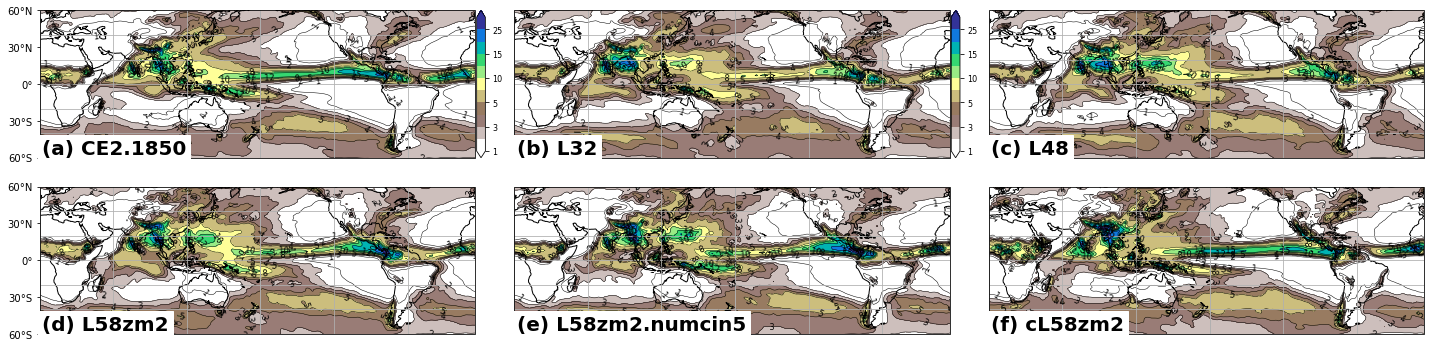

In [83]:
# Check #case and plot spaces.
ncases = case_desc.size
nplots = nrow*ncol

if ncases > nplots: 
    print('')
    print('*** nrow*ncol does not math ncases - exiting ***') 
    exit('nplot,ncase mi-match')

########## SET UP LAT LON PLOTS ##############

nseas = seas.size # Different for different seasons

if nseas==1:
    axes_pad = 0.4 ; share_all=False ; cbar_location='right' ; cbar_mode='each' ; cbar_pad = 0.02 ; cbar_size = '2%'
else:
    axes_pad = 0.1 ; share_all=False ; cbar_location='right' ; cbar_mode='edge' ; cbar_pad = 0.02 ; cbar_size = '2%'




# Grab/Process data
mscale = pvars_df.loc[var_name]['mscale']
# Set up graphics
#pproj = ccrs.Mollweide(central_longitude=0.0)
pproj = ccrs.PlateCarree(central_longitude=180.0)
#pproj = ccrs.EckertV(central_longitude=-180.)


axes_class = (GeoAxes,dict(map_projection=pproj))

#mp.rcParams["mpl_toolkits.legacy_colorbar"] = False
fig = mp.figure(figsize=(25, 16))

axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(nrow, ncol),
                    axes_pad=axes_pad,
                    share_all=share_all,
                    cbar_location=cbar_location,
                    cbar_mode=cbar_mode,
                    cbar_pad=cbar_pad,
                    cbar_size='2%',
                    label_mode='')  # note the empty label_mode

# lat,lon Contouring choices #

#mp.close()

cmin  = pvars_df.loc[var_name]['cmin'] ; cmax = pvars_df.loc[var_name]['cmax']
acmin = pvars_df.loc[var_name]['acmin']; acmax = pvars_df.loc[var_name]['acmax']

dcont = (cmax-cmin)/ncint ; adcont = (acmax-acmin)/ancint

plevels =  np.arange(cmin,cmax+dcont,dcont,dtype=float)
aplevels = np.arange(acmin,acmax+adcont,adcont,dtype=float)

if var_name == 'PRECT':
    plevels = np.array([1,2,3,4,5,8,10,12,15,20,25,30])
    aplevels = 0.5*np.array([-15,-12,-8,-6,-4,-3,-2,-1,0,1,2,3,4,6,8,12,15])

if var_name == 'AODVIS':
    plevels = np.array([0.05,0.1,0.15,0.2,0.3,0.4,0.6,0.8,1.0,1.5,2.0,2.5])
    aplevels = np.array([-1.,-0.5,-0.2,-0.1,-0.05,-0.025,-0.01,-0.005,0.,0.005,0.01,0.025,0.05,0.1,0.2,0.5,1.])
    
 


############### SETUP ZONAL AVERAGE PLOTS ################

if lp3d_if_read_in:
    axzm_zm,axs_zm = mp.subplots(nrows=nrow, ncols=ncol,figsize=[16, 10])
    
# These array counters are just for the ax of the zm plots.
irow = np.zeros((nplots),dtype=int)
icol = np.zeros((nplots),dtype=int)

for ii in range(0,nrow): irow[ii*ncol:ii*ncol+ncol] = ii 
for ij in range(0,nrow): icol[ij*ncol:ij*ncol+ncol] = np.arange(0,ncol,1)

#### PLOTTING ###
    
print('+++++ Plotting +++++ '+var_name)
print('# cases = ',ncases)
            
pvar_ctrl = None










###################################
#### LOOP Cases and Subfigures ####
###################################
 
    
for iseas, this_seas in enumerate(seas):
    pvar3d_ctrl = None
    pvar_ctrl = None
    
    if nseas==1:  
        isub0 = 0 ; isub1 = ncases ; isub_step = 1 
    else :       
        isub0 = iseas ; isub1 = 2*ncases+iseas-nseas+2 ; isub_step = nseas 
    
    iplots = np.arange(isub0,isub1,isub_step)
    
    print('++++ SEASON = ',seas[iseas])
    
    
    for icase, ax in enumerate(axgr[isub0:isub1:isub_step]):
        
        pvar = None # Reset
       
        cdesc = case_desc[icase] 
        cname = cases_df.loc[cdesc]['run name']
        mscale = pvars_df.loc[var_name]['mscale']   
        
        print(icase)
        
        izm = irow[icase] ; jzm = icol[icase] # Paneling indices      
        
        if cdesc=='CE2':
            file_in = dir_root+cname+'/yrs_1979-2005/'+cname+'_'+this_seas+'_climo.nc'
        else :
            file_in = dir_root+cname+'/0.9x1.25/'+cname+'_'+this_seas+'_climo.nc'
    
    
        print('')
        print('Case ',(icase+1),' of ',ncases,' -> '+cdesc+' - '+cname)
        print('-File = '+file_in)
        print('')
    
       
    
## Read in variable data ##   

        case_nc =  xr.open_dataset(file_in,engine='netcdf4')
   
# Composite variables #
        if var_name == 'PRECT': 
            pvar = case_nc['PRECC'].isel(time=0)+case_nc['PRECL'].isel(time=0) 
        
        
# Interpolated from 3D variable # 

        if l3d_var: 
        
            print('++ Interpolating from 3D field ##')
            pvar3d = case_nc[var_name_in].isel(time=0) # Read in 3D variable
#        pvar3d = units.Quantity(case_nc[var_name_in])
            pvar3d.squeeze()
    
                
            print('')
            pres_levu = plev_val * units.hPa # Set interpolation level (in hPa)
        
# Read in vars required for interpolation and 3D pressure values
            ps,P0,hyam,hybm =  case_nc['PS'].isel(time=0).squeeze(),case_nc['P0'],case_nc['hyam'],case_nc['hybm']
        
            pres_lev = pvar3d.copy(deep=True) # Make meta copy from the 3d variable
            pres_lev = hyam*P0 + hybm*ps # Change values to 3D pressure.
            pres_lev = units.Quantity(pres_lev, 'Pa') # Attach metpy units

# Perform vertical interpolation

            pvar = ps.copy(deep=True) # Copy off meta data from the 2D PS field.
      
            pvar = log_interpolate_1d(pres_levu, pres_lev, pvar3d, axis=0) # Annoying as all the meta data is lost.
            pvar = pvar.squeeze()
            pvar = xr.DataArray(pvar, coords=[pvar3d.lat, pvar3d.lon], dims=["lat", "lon"])
        
# Save off mean/ctrl
            if pvar3d_ctrl is None: pvar3d_ctrl = pvar3d
        
            if icase > 0 and ldiff_ctrl:
                pvar3d = np.subtract(pvar3d,pvar3d_ctrl)
                pvar3d = pvar3d.interp(lat=pvar3d_ctrl.lat,lon=pvar3d_ctrl.lon) if cdesc == 'C5' else pvar3d
        
# Standard 2D variable read.
        if pvar is None: 
            pvar = case_nc[var_name_in].isel(time=0).squeeze()
   
        pvar = mscale*pvar # Scale to useful units.
 
        lon = case_nc['lon']    
        lat = case_nc['lat']
   
## Retain control case data ##   
        if pvar_ctrl is None: pvar_ctrl = pvar
   
## Contouring (full or anom) ##

        clevels = plevels   
        levs_4colbar = clevels
      
        cmap = pvars_df.loc[var_name]['cmap']      
       
    
## Modify if anom plot ##   
     
        if icase > 0 and ldiff_ctrl:
        
    
# I think CAM5 coords are slighly misalligned so have to interpolate to the pvar_ctrl (mostly CAM6/C6)
            pvar = pvar.interp(lat=pvar_ctrl.lat,lon=pvar_ctrl.lon) if cdesc == 'C5' else pvar
            pvar = np.subtract(pvar,pvar_ctrl)
            levs_4colbar = aplevels
            
            
            
            cmap = pvars_df.loc[var_name]['acmap'] 
       
        clevels = levs_4colbar[abs(levs_4colbar) > 1.e-15] # Remove zero contour, but somtimes it can be very small as well.
        
## Plotting for each ax ##  
# Domain, this seems flakey for cartopy ##
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=pproj)
        ax.coastlines(linewidth=1)
        ax.gridlines()
        ax.add_feature(cartopy.feature.LAND, zorder=0)
        
#        ax.set_xticks(np.linspace(180., 180, 5), crs=pproj)
        
        if jzm==0 and nseas==1: # Just the left hand panels.
            ax.set_yticks(np.linspace(lat_min, lat_max, 5), crs=pproj)   
            lat_formatter = LatitudeFormatter()
            ax.yaxis.set_major_formatter(lat_formatter)
            
## Add Cyclic Point ## 
        print(pvar)
        print(pvar.lon)
        pvarc,lonc = cutil.add_cyclic_point(pvar,coord=pvar.lon)
        

## Translate to -180->+180 - maddening

        ilon_pivot = int(lon.size/2)+1
        pvarc = np.roll(pvarc, ilon_pivot, axis=1) # 144 points will roll you from 0-360 ->-180-180 data   

## CONTOUR PLOT (normalize colorbar for non-linear intervals) ##    
        norm = cm.colors.BoundaryNorm(boundaries=levs_4colbar, ncolors=256)
        pplot = ax.contourf(lonc, lat, pvarc,transform=pproj,cmap=cmap, extend='both',levels=clevels,norm=norm)
        
       
#### COLORBARS - Don't need one on every figure. #####  
        axgr.cbar_axes[icase].colorbar(pplot) # Plot individual color bars before line contour screws it up!    
#        pplot = mpl.colorbar.ColorbarBase(axgr.cbar_axes[icase], ticks=levs_4colbar[::2], # Every other tick.
#            cmap=cmap,boundaries=levs_4colbar,orientation='vertical',norm=norm)
        axgr.cbar_axes[icase].tick_params(labelsize=8) 
        
        if ldiff_ctrl: # Make sure smallest contour intervals are white
            pplot = ax.contourf(lonc, lat, pvarc,levels=[-min(abs(clevels)),min(abs(clevels))], colors='w')
        
### Remove the colorbar entirely for these panels (just need two, 1 for full and 1 for anoms)
        if icase in np.arange(2,ncases,1) and iseas==nseas-1:    
            pplot = mpl.colorbar.ColorbarBase(axgr.cbar_axes[icase]).remove()     
        
        
#### LINE PLOT  ####
        pplot = ax.contour (lonc, lat, pvarc,transform=pproj
            ,levels=clevels,colors='black',linewidths=0.5)

        del(lonc) ; del(pvarc)
    
#### ADD PLOT TEXT/TITLE ####

        if icase==0 and nseas>1 :
            bbox=dict(boxstyle = "square",facecolor = "white")
            ax.text(-170., 40., seas[iseas],fontsize=20,fontweight='bold',bbox=bbox,zorder=10)
            
        if iseas==0:
            cdesc_fig = cdesc if not lcase_lname else case_lname[icase]
            ax.text(lon_min+2, lat_min+3., fig_let[icase]+cdesc_fig,fontsize=20,fontweight='bold',backgroundcolor = 'white',zorder=10)

    
    #### CONTOUR LABELING ####
    
        ax.clabel(
            pplot,  # Typically best results when labelling line contours.
            colors=['black'],
            fontsize=8,
            manual=False,  # Automatic placement vs manual placement.
            inline=False,  # Cut the line where the label will be placed.
            fmt=' {:.0f} '.format,  # Labels as integers, with some extra space.
        )    

    ## ZM PLOTS ##

        if lp3d_if_read_in:
            pvar_zm = pvar3d.loc[:,lat_min:lat_max,lon_ave_w:lon_ave_e].mean(dim='lon') # Calc. zonal average
            lat_p = lat.loc[lat_min:lat_max]
            
#            print(axs_zm[izm,jzm].__dict__)
            if izm==nrow-1:
                axs_zm[izm,jzm].set_xlabel("Latitude", fontsize = 8) 
            if jzm==0:
                axs_zm[izm,jzm].set_ylabel("Pressure (mb)", fontsize = 8)
                
            axs_zm[izm,jzm].set_xticks(np.linspace(-90, 90, 7))   
            
            
            axs_zm[izm,jzm].set_title(fig_let[icase]+cdesc, x=0.72, y=0.02,fontweight ="bold",fontsize = 10,
                horizontalalignment='left',backgroundcolor = 'white')

            zm_plot = axs_zm[izm,jzm].contourf(lat_p, pvar_zm.lev, pvar_zm,levels=clevels,cmap=cmap,extend='both')

            fig_zm.colorbar(zm_plot,ax=axs_zm[izm,jzm],ticks=levs_4colbar[::2],pad=0.01)

            axs_zm[izm,jzm].tick_params(labelsize=8) # Change axis values font height. 
# Contouring
            zm_plot = axs_zm[izm,jzm].contourf(lat_p, pvar_zm.lev, pvar_zm,levels=[-1,1], colors='w')
            zm_plot = axs_zm[izm,jzm].contour(lat_p, pvar_zm.lev, pvar_zm,colors='black',linewidths=1.0,levels=clevels)
            
            axs_zm[izm,jzm].invert_yaxis()  
            axs_zm[izm,jzm].set_ylim([1000.,50.])

    ## Contour labaling ##
            ax.clabel(
                zm_plot,  # Typically best results when labelling line contours.
                colors=['black'], 
                fontsize=10,
                manual=False,  # Automatic placement vs manual placement.
                inline=True,  # Cut the line where the label will be placed.
                fmt=' {:.0f} '.format)  # Labels as integers, with some extra space.

#    mp.close()


#  Output fig
   
    if nseas==1:
        mp.savefig('vres_FWscHIST__'+var_name+'_'+seas[0]+'.png', dpi=300, bbox_inches='tight')  
    else :
        mp.savefig('vres_FWscHIST_'+var_name+'.png', dpi=300, bbox_inches='tight') 

#if l3d_var:
#    mp.savefig('CAM6_oview_zm_'+var_name_in+'_'+seas+'.png', dpi=300, bbox_inches='tight')

## Control, revert and SST simulation names

In [49]:
#####################################
# CAM6 Revert Experiments + others   
#####################################


def cam_revert_list():
	

    rl = {} # Revert List
# Releases
    rl['C4']   =  ['f40.1979_amip.track1.1deg.001']
    rl['C5']   =  ['30L_cam5301_FAMIP.001']
    rl['C6']   =  ['f.e20.FHIST.f09_f09.cesm2_1.001']
    rl['CC4']  =  ['b40.20th.track1.1deg.012']
    rl['CE1']  =  ['b.e11.B20TRC5CNBDRD.f09_g16.001']
    rl['CE2']  =  ['b.e21.BHIST.f09_g17.CMIP6-historical.001']
    rl['CE2.1850']  =  ['b.e20.B1850.f09_g17.pi_control.all.297']

    # Reverts
    rl['rC5now']  =   ['f.e20.FHIST.f09_f09.cesm2_1_cam5.001']
    rl['rC5']     =   ['f.e20.FHIST.f09_f09.cesm2_1_true-cam5.001']
    rl['rC5t']    =   ['f.e20.FHIST.f09_f09.cesm2_1_true-cam5_param_topo.001']
    rl['rUWold']  =   ['f.e20.FHIST.f09_f09.cesm2_1_uw.001']
    rl['rGW']    =   ['f.e20.FHIST.f09_f09.cesm2_1_iogw.001']
    rl['rZMc']  =   ['f.e20.FHIST.f09_f09.cesm2_1_capeten.001']
    rl['rMG1']  =   ['f.e20.FHIST.f09_f09.cesm2_1_mg1.001']
    rl['rSB']  =   ['f.e20.FHIST.f09_f09.cesm2_1_sb.002']
    rl['rTMS']  =   ['f.e20.FHIST.f09_f09.cesm2_1_tms.001']
    rl['rCE2i']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revert125.001']
    rl['rC5p']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertcam5param.001']
    rl['rC5pm']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertcam5param.002']
    rl['rZMp']  =   ['f.e20.FHIST.f09_f09.cesm2_1_cam5_zmconv.001']
    rl['rM3']  =   ['f.e20.FHIST.f09_f09.cesm2_1_mam3.001']
    rl['rUW']  =   ['f.e20.FHIST.f09_f09.cesm2_1_uw.002']
    rl['rUWp']  =   ['f.e20.FHIST.f09_f09.cesm2_1_uw.003']
    rl['rMG1ii']  =   ['f.e20.FHIST.f09_f09.cesm2_1_mg1.002']
    rl['rice']  =   ['f.e20.FHIST.f09_f09.cesm2_1_ice-micro.001']
    rl['rpfrac']  =   ['f.e20.FHIST.f09_f09.cesm2_1_precip_frac_method.001']
    rl['rpremit']  =   ['f.e20.FHIST.f09_f09.cesm2_1_cld_premit.001']
    rl['rC5psalt']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertc5seasalt.001']
    rl['rC5pdust']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertc5dust.001']
    rl['rL30']  =   ['f.e20.FHIST.f09_f09.cesm2_1_L30.001']
    
# SST configs    
    rl['AMdsst'] = ['f.e20.FHIST.f09_f09.cesm2_1_reynolds_daily_sst.006']
    rl['CE2dsst']  =   ['f.e20.FHIST.f09_f09.cesm2_1_coupled-sst-amip_daily.001']
    rl['CE2sst']  =   ['f.e20.FHIST.f09_f09.cesm2_1_coupled-sst-amip.001']
    rl['CE2csst']  =   ['f.e20.FHIST.f09_f09.cesm2_1_coupled-sst-climo.001']
    
# Vertical resolution plots

# vres runs
    
    rl['C5']   =  ['30L_cam5301_FAMIP.001']
    rl['C6']   =  ['f.e20.FHIST.f09_f09.cesm2_1.001']
#    rl['L48']       =  ['f.e21.FWscHIST_BGC.ne30_ne30_mg17_L48_revert-J.001']
    rl['L48cin5']   =  ['f.e21.FWscHIST_BGC.ne30_ne30_mg17_L48_revert-J_num_cin-5.001']
    rl['L110'] = ['f.e21.FWscHIST_BCG.f09_f09_mg17_110L.001']
    rl['L48.BL10']=['f.e21.FWscHIST.ne30_L48_BL10_v3_tag20201111.001']
    rl['L48.BL10.zm1']=['f.e21.FWscHIST.ne30_L48_BL10_v3_tag20201111_zm1.001']
    rl['L48.BL10.zm2']=['f.e21.FWscHIST.ne30_L48_BL10_v3_tag20201111_zm2.001']
    
    rl['L32'] = ['f.e21.FWscHIST.ne30_L32_cam6_3_019_plus_CESM2.2.001.hf']
    rl['L48'] = ['f.e21.FWscHIST.ne30_L48_cam6_3_019_plus_CESM2.2.001.hf']
    rl['L58'] = ['f.e21.FWscHIST.ne30_L48_BL10_cam6_3_019_plus_CESM2.2.001.hf']
    rl['L58zm2'] = ['f.e21.FWscHIST.ne30_L48_BL10_cam6_3_019_plus_CESM2.2.001_zm2.hf']
    rl['L58zm2.numcin5'] = ["f.e21.FWscHIST.ne30_L48_BL10_cam6_3_019_plus_CESM2.2.001_zm2_numcin5.hf"]
    rl['cL58zm2'] = ['b.e21.BWsc1850.ne30_L48_BL10_cesm2_3_alpha05c_cam6_3_028_cam6_parcel_zm.004_zm2.hf']
# Data frame
    rl_df = pd.DataFrame.from_dict(rl, orient='index',columns=['run name'])
    return rl_df